In [1]:
import plotly
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Plotly

In [2]:
df = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/new_norm.csv')

In [3]:
plotly.tools.set_credentials_file(username='n8pk', api_key='g7okPTh6GZXW7gKoxdJh')

In [48]:
# For top 12
# scl = [[0.00, 'rgb(255,204,255)'],[0.005, 'rgb(255,204,255)'],\
#        [0.006, 'rgb(255,255,0)'],[0.02, 'rgb(255,255,0)'],\
#        [0.03, 'rgb(102,255,0)'],[0.08, 'rgb(102,255,0)'],\
#        [0.09, 'rgb(0,51,0)'],[1.00, 'rgb(0,51,0)']]

# For top 8
scl = [[0.00, 'rgb(255,204,255)'],[0.005, 'rgb(255,204,255)'],\
       [0.006, 'rgb(204,255,204)'],[0.02, 'rgb(204,255,204)'],\
       [0.03, 'rgb(255,255,0)'],[0.06, 'rgb(255,255,0)'],\
       [0.07, 'rgb(102,255,0)'],[0.37, 'rgb(102,255,0)'],\
       [0.38, 'rgb(0,51,0)'],[1.00, 'rgb(0,51,0)']]



df['text'] = df['geography'] + '<br>' +\
             'Years with medical marijuana:'+ '<br>' +\
              df['years_med'].astype(str) + '<br>' +\
             'Population with college degree:'+ '<br>' +\
              round(df['college_ratio']*100,2).astype(str)+'%'

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['code'],
        z = df['norm_prob'],
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(0,0,0)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Probability Density")
        ) ]

layout = dict(
#         title = 'Normalized Probability of Legalization'+'<br>'+\
#                 'Hover for AUC and relevant metrics'+'<br>'+\
#                 '(Metrics & Predictions for 2016)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
        showlegend = False
             )
    
fig = dict( data=data, layout=layout )

#plotly.offline.plot( fig, filename='/home/nate/ds/metis/class_work/projects/project_mcnulty/choropleth-map.html' );
plotly.plotly.plot(fig, filename='us_recreation_map');

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~n8pk/0 or inside your plot.ly account where it is named 'us_recreation_map'


# Matplotlib

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix

In [14]:
df_12 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_12_altered.csv')
df_13 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_13_altered.csv')
df_14 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_14_altered.csv')
df_15 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_15_altered.csv')
df_16 = pd.read_csv('/home/nate/ds/metis/class_work/projects/clean_data/df_16_altered.csv')

## Confusion Matrix

In [15]:
test = df_16

train_years = [df_12, df_13, df_14, df_15]
train_whole = pd.concat(train_years).reset_index(drop=True)

X_train = np.array(train_whole[
    ['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_train = np.array(train_whole['rec_legal'])

X_test = np.array(test[
    ['white_ratio', 'college_ratio', 'years_med']]).reshape(-1,3)
y_test = np.array(test['rec_legal'])

In [16]:
lr = LogisticRegression(penalty='l1', C=0.1, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)
lr_probs = []
for pred in lr_pred[:,1]:
    if pred < 0.3:
        lr_probs.append(0)
    else:
        lr_probs.append(1)

gbc = GradientBoostingClassifier(n_estimators=6, learning_rate=0.1, max_features=None, max_depth= 2, random_state=42)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict_proba(X_test)
gbc_probs = []
for pred in gbc_pred[:,1]:
    if pred < 0.19:
        gbc_probs.append(0)
    else:
        gbc_probs.append(1)

In [17]:
gbc_matrix = confusion_matrix(y_test, gbc_probs)
lr_matrix = confusion_matrix(y_test, lr_probs)

np.set_printoptions(precision=2)

In [32]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    
    '''
    make a pretty plot for confusion matrix
    '''
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    plt.imshow(cm, cmap)
    plt.title(title, fontweight='bold')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    text = ['Specificity',' ','Recall']
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, (text[i+j] + '\n' + format(cm[i, j], fmt)),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')

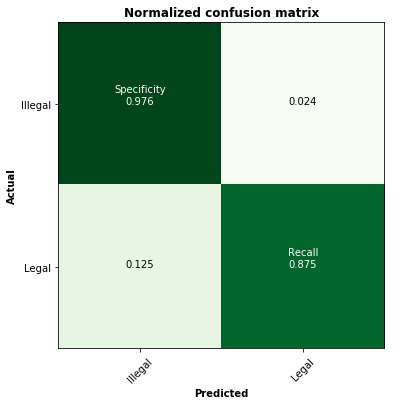

In [33]:
plt.figure(figsize=(9,6))
plot_confusion_matrix(lr_matrix, classes=['Illegal', 'Legal'],
                      normalize=True, title='Normalized confusion matrix',
                      cmap=plt.cm.Greens);

## Scatters

In [20]:
plt_old = df_15.copy()

trues_old = plt_old.groupby(['rec_legal']).get_group(1)
falses_old = plt_old.groupby(['rec_legal']).get_group(0)

illegals_old = falses_old.groupby(['years_med']).get_group(0)

void_old = list(illegals_old['Unnamed: 0'])

medical_old = []
for idx, row in falses_old.iterrows():
    if idx not in void_old:
        medical_old.append(row)

medicals_old = pd.DataFrame(medical_old)

''

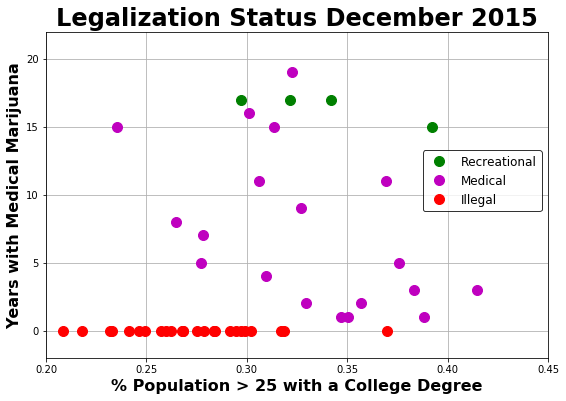

In [41]:
plt.figure(figsize=(9,6))

plt.title('Legalization Status December 2015', fontweight='bold', fontsize=24)
plt.xlabel('% Population > 25 with a College Degree', fontweight='bold', fontsize=16)
plt.ylabel('Years with Medical Marijuana', fontweight='bold', fontsize=16)

plt.grid()
plt.xlim(0.2,0.45)
plt.ylim(-2,22)
plt.plot(trues_old['college_ratio'], trues_old['years_med'], 'go', label='Recreational', ms=10)
plt.plot(medicals_old['college_ratio'], medicals_old['years_med'], 'mo', label='Medical', ms=10)
plt.plot(illegals_old['college_ratio'], illegals_old['years_med'], 'ro', label='Illegal', ms=10)
plt.legend(loc=(0.75,0.45), prop={'size': 12}, edgecolor='k')

;

In [43]:
plt_data = df_16.copy()

trues = plt_data.groupby(['rec_legal']).get_group(1)
falses = plt_data.groupby(['rec_legal']).get_group(0)

illegals = falses.groupby(['years_med']).get_group(0)

void = list(illegals['Unnamed: 0'])

medical = []
for idx, row in falses.iterrows():
    if idx not in void:
        medical.append(row)

medicals = pd.DataFrame(medical)

''

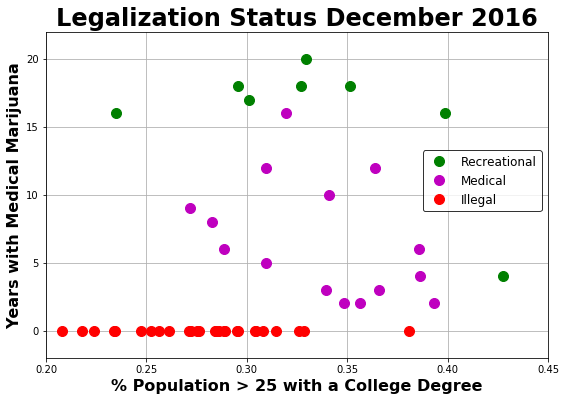

In [44]:
plt.figure(figsize=(9,6))

plt.title('Legalization Status December 2016', fontweight='bold', fontsize=24)
plt.xlabel('% Population > 25 with a College Degree', fontweight='bold', fontsize=16)
plt.ylabel('Years with Medical Marijuana', fontweight='bold', fontsize=16)

plt.grid()
plt.xlim(0.2,0.45)
plt.ylim(-2,22)
plt.plot(trues['college_ratio'], trues['years_med'], 'go', label='Recreational', ms=10)
plt.plot(medicals['college_ratio'], medicals['years_med'], 'mo', label='Medical', ms=10)
plt.plot(illegals['college_ratio'], illegals['years_med'], 'ro', label='Illegal', ms=10)
plt.legend(loc=(0.75,0.45), prop={'size': 12}, edgecolor='k')
;

In [49]:
preds = df.sort_values(['norm_prob'], ascending=False).head(12)
preds = preds['geography']

pred_points = []

for idx, row in plt_data.iterrows():
    if row[1] in list(preds):
        pred_points.append(row)
        
pred_df = pd.DataFrame(pred_points)

''

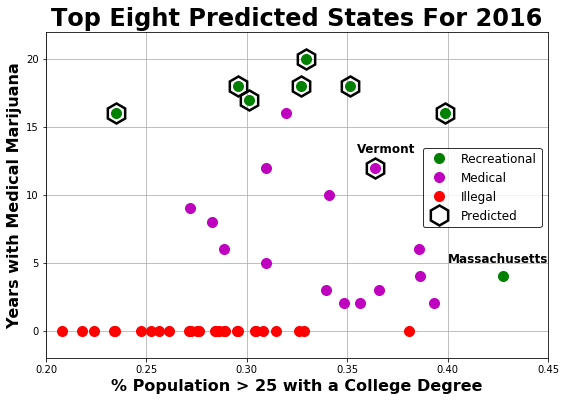

In [46]:
# set preds.head to 8

plt.figure(figsize=(9,6))

plt.title('Top Eight Predicted States For 2016', fontweight='bold', fontsize=24)
plt.xlabel('% Population > 25 with a College Degree', fontweight='bold', fontsize=16)
plt.ylabel('Years with Medical Marijuana', fontweight='bold', fontsize=16)

plt.text(0.355, 13.1, 'Vermont', fontweight='bold', fontsize=12)
plt.text(0.4, 5, 'Massachusetts', fontweight='bold', fontsize=12)

plt.grid()
plt.xlim(0.2,0.45)
plt.ylim(-2,22)
plt.plot(trues['college_ratio'], trues['years_med'], 'go', label='Recreational', ms=10)
plt.plot(medicals['college_ratio'], medicals['years_med'], 'mo', label='Medical', ms=10)
plt.plot(illegals['college_ratio'], illegals['years_med'], 'ro', label='Illegal', ms=10)
plt.plot(pred_df['college_ratio'], pred_df['years_med'], 'h', markerfacecolor='None',
         markeredgecolor='k', markeredgewidth=2.5, ms=20, label='Predicted')
plt.legend(loc=(0.75,0.4), prop={'size': 12}, edgecolor='k')
;

''

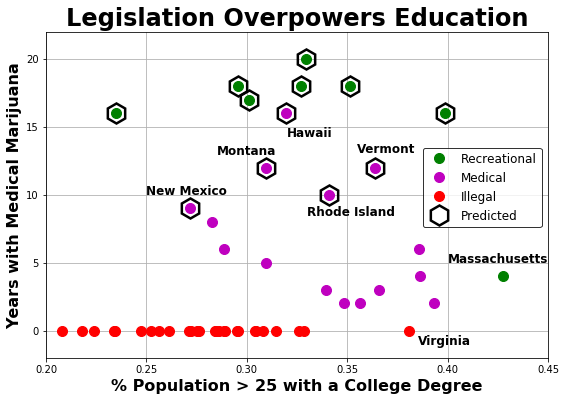

In [50]:
# set preds head to 12

plt.figure(figsize=(9,6))

plt.title('Legislation Overpowers Education', fontweight='bold', fontsize=24)
plt.xlabel('% Population > 25 with a College Degree', fontweight='bold', fontsize=16)
plt.ylabel('Years with Medical Marijuana', fontweight='bold', fontsize=16)

plt.text(0.355, 13.1, 'Vermont', fontweight='bold', fontsize=12)
plt.text(0.4, 5, 'Massachusetts', fontweight='bold', fontsize=12)
plt.text(0.32, 14.3, 'Hawaii', fontweight='bold', fontsize=12)
plt.text(0.285, 13, 'Montana', fontweight='bold', fontsize=12)
plt.text(0.33, 8.5, 'Rhode Island', fontweight='bold', fontsize=12)
plt.text(0.25, 10, 'New Mexico', fontweight='bold', fontsize=12)
plt.text(0.385, -1, 'Virginia', fontweight='bold', fontsize=12)

plt.grid()
plt.xlim(0.2,0.45)
plt.ylim(-2,22)
plt.plot(trues['college_ratio'], trues['years_med'], 'go', label='Recreational', ms=10)
plt.plot(medicals['college_ratio'], medicals['years_med'], 'mo', label='Medical', ms=10)
plt.plot(illegals['college_ratio'], illegals['years_med'], 'ro', label='Illegal', ms=10)
plt.plot(pred_df['college_ratio'], pred_df['years_med'], 'h', markerfacecolor='None',
         markeredgecolor='k', markeredgewidth=2.5, ms=20, label='Predicted')
plt.legend(loc=(0.75,0.4), prop={'size': 12}, edgecolor='k')
;